In [ ]:
try:
    import control as ctl
except ImportError as e:
    # Install Python-Control package
    !pip install control
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

## 1 - Modélisation sur Simulink : obtention du PID

### 1.1 - Calcul de la fonction de **transfert**

 **Le modèle Simulink**

Le système a été modélisé sous la forme :






![][image1]

[image1]: <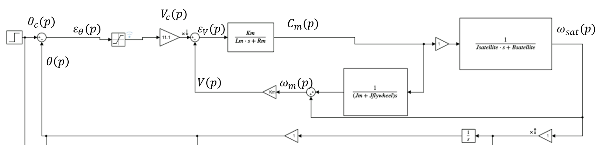>



Nous allons chercher à simplifier ce modèle.


**Mise en equation**

Commençons par poser les différentes équations de notre système. Nous supposons que les frottements du satellite sont négligeables.

Les équations électriques:

$ U = R*i + L * \frac{d_i}{d_t} + e $

avec $ e= K * (ω_{rotor}+ω_{satellite}) $

Les équations mécaniques:

$ J_{rotor} * \frac{d_ωrotor}{d_t} = C = K * i $

$ J_{satellite} * \frac{d_ωsatellite}{d_t} = K * i$

On en déduit : $ω_{rotor} = ω_{satellite} * \frac{J_{satellite}}{J_{rotor}} $

Nous supposons $\frac{d_i}{d_t}$ négligeable car ($\frac{L}{R}$ est petit). Ainsi nous simplifions et passons dans le domaine de la Laplace:

(1) $ U(p) = R*i(p) + K*(1+\frac{J_{satellite}}{J_{rotor}})*ω_{satellite}(p) $


(2) $ J_{satellite} * p * ω_{satellite}(p) = K * i(p) $

Soit $ U(p) = \frac{R}{K}*J_{satellite} * p * ω_{satellite}(p) + K*(1+\frac{J_{satellite}}{J_{rotor}})*ω_{satellite}(p) $

Ce qui nous donne cette fonction de transfert en boucle ouverte en vitesse:

$ \frac{ω_{satellite}(p)}{U(p)} = \frac{1}{\frac{R}{K}*J_{satellite} * p + K*(1+\frac{J_{satellite}}{J_{rotor}})} $

En mettant la fonction de transfert en boucle ouverte sous la forme $ \frac{G}{1+τ*p} $, voici ce que nous obtenons:

$ G= \frac{1}{K*(1+\frac{J_{satellite}}{J_{rotor}})}= \frac{J_{rotor}}{K*(J_{rotor}+J_{satellite})} $

$ τ=\frac{R}{K^2} * \frac{J_{satellite}}{1+\frac{J_{satellite}}{J_{rotor}}}  $

Cependant, nous cherchons à récupérer en sortie la position du satellite et non pas ça vitesse pour cela il nous faut rajouter un intégrateur:

$ \frac{θ_{satellite}(p)}{U(p)} = \frac{G}{p+τ*p^2} $









**Le capteur**

Précédemment nous avons pris en compte le moteur, la roue d'inertie et le satellite, néanmoins nous n'avons pas pris en compte le capteur.
Le capteur a une bande passante limitée. Sa fonction de transfert s'exprime sous cette forme $ H(p)=\frac{1}{1+τ_m*p}$
Nous supposons que $f_{satellite} = 10 $ Hz, d'où $ τ_s=\frac{1}{f_{satellite}}=0.2 s$

Donc $ τ_m = \frac{τ_s}{2} = 0.1 s $  

**Schéma bloc**

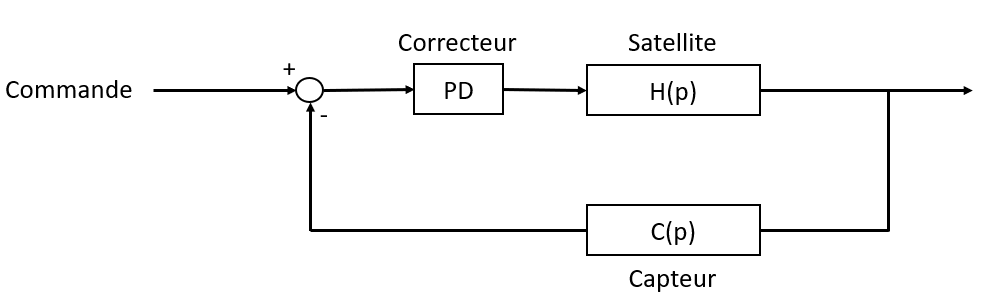

**Affichage de la fonction de transfert en boucle ouverte sans correcteur sur Python**

In [ ]:
# Parameters

#--- Motor Constants ---
Km = 1.59e-2 #[N.m/A] Motor Constant
Lm = 4.653e-3 #[H] Motor Inductance
Rm = 18 #[Ohms] Motor resistance
Jm = 1.89922e-7 #[kg.m²] Motor Inertia

#--- Satelite Constants ---
Jsat = 4.0806e-4  #[kg.m²] Satelite Inertia
Bsat = 4.7047e-7 #[N.s/m] Satelite viscous friction

#--- Flywheel Constants ---
Jflywheel = 1.0485e-5  #[kg.m²] Flywheel Inertias
Jrotor=Jflywheel+Jm #[kg.m²] Flywheel and rotor Inertias

#--- Sensor Constants ---
fs=10 #[Hz] acquisition frequency


In [ ]:
# Transfer Function

# --- Paramètres ----
G=11.1*Jrotor/(Km*(Jrotor+Jsat))
Tau= Rm*Jsat / (Km **2 * (1+(Jsat/Jrotor)))
print(f"Pole du satellite : {Tau} s")
print(f"Gain du satellite : {G} ")
ts=1/fs
tm=ts/2
print(f"Pole du capteur : {tm} s")
#Sensor Bandwidth
omega_c = 1/tm




Pole du satellite : 0.74067521125376 s
Gain du satellite : 17.797187782049495 
Pole du capteur : 0.05 s


<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   24.03
------------
s^2 + 1.35 s

<TransferFunction>: sys[8]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    1
----------
0.05 s + 1

<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   24.03
------------
s^2 + 1.35 s

Voici le bode de la fonction de transfert en boucle ouverte sans PID et avec  capteur


/usr/local/lib/python3.10/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


<TransferFunction>: sys[11]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


           1.201 s + 24.03
-------------------------------------
0.05 s^3 + 1.068 s^2 + 1.35 s + 24.03



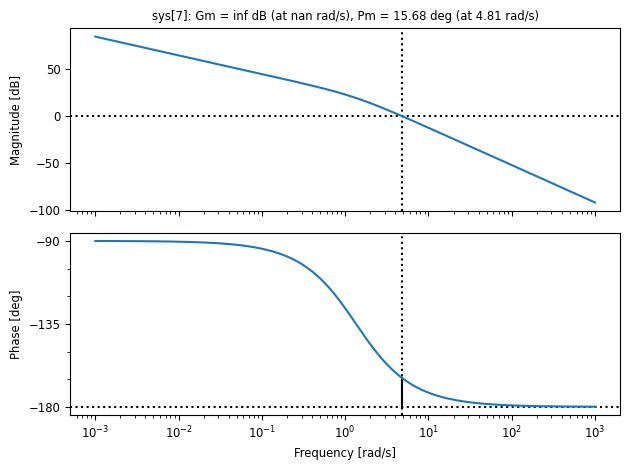

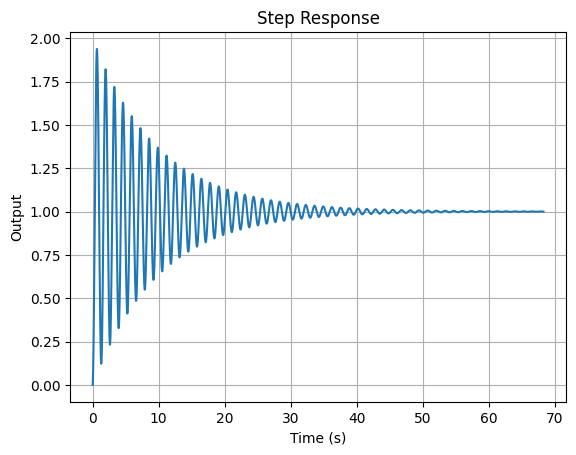

In [ ]:
#Transfer Function
Satellite = ctl.tf([G/Tau],[1,1/Tau,0])
print(Satellite)
Sensor = ctl.tf([1],[tm,1])
print(Sensor)
hbo=Satellite
print(hbo)

omega = np.logspace(-3, 3, 5000)  # de 0.1 à 100 rad/s, 5000 points

# Bode diagram
print("Voici le bode de la fonction de transfert en boucle ouverte sans PID et avec  capteur")
mag, phase, omega= ctl.bode_plot(hbo, omega=omega, plot=True, Hz=False, dB=True,deg=True, initial_phase=0,display_margins=True)

hbf_ass = ctl.feedback(Satellite,Sensor,-1)
print(hbf_ass)
plt.show()

# ---- Réponse système asservi ----

#T = np.linspace(1, 5, 1000)
t, y = ctl.step_response(hbf_ass)

plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response')
plt.grid(True)
plt.show()

### 1.2 - Modélisation du correcteur : choix du PD

#### 2.1.1 - Détermination des performances de notre système asservi

Pour pouvoir determiner le correcteur, il faut d'abord determiner les caractéristiques (*stabilité, rapidité et précision*) du système asservi.

Comme nous n'avions pas de critère de défini très précisément, nous avons choisi des paramètres qui nous semblait cohérent, mais que nous pourrons faire varier s'ils ne nous conviennent pas :
*   *Rapidité* : Bande passante limitée par celle du capteur  $[0 ; 10 \ Hz]$, ce qui nous donne une fréquence de coupure à $\omega_{c'} =  \ rad/s$
*   *Stabilité* : Une marge de phase à $ 60 ° $
*   *Précision* : Une precision en position à  $ ϵ_p = 0 $ (déjà obtenue grâce à l'integrateur)

#### 2.1.2 - Calcul des paramètres du PD


**Le correcteur**

Un intégrateur pur est déjà présent, nous n'avons pas d'avoir un integrateur dans notre correcteur.
Nous pouvons donc partir sur un PD: $ C(p)=K_d(1+τ_dp)$

Pour avoir un correcteur causal, on ajoute un coefficient de filtrage N (très grand) pour avoir un dénominateur avec un effet négligeable sur le comportement du système.

$ C(p)=K_d*\frac{1+τ_dp}{1+\frac{τ_d}{N}p}$


**Calcul du D**

Pour le $τ_d$, on cherche a élimiter le pole le plus lent, qui est dans notre cas celui du moteur $τ$:

$τ_d = τ $

Pour le gain, il faut determiner les caractéristiques de la fonction de transfert en boucle ouverte de notre  système à asservir.

La fonction de transfert a changé grâce à la simplification. Comme le terme du denominateur du correcteur est négligeable, on peut écrire la fonction en boucle ouverte asservie de cette manière :

$H_{bo,ass}(p)= H_{bo}(p)*PD(p)=K_d*\frac{G}{(tm*p +1)p}$

La fonction en boucle ouverte non asservie s'ecrit donc comme cela :

$H_{bo,simplified}(p)= \frac{G}{(tm*p +1)p}$


**Calcul du K**
On calcule le gain nécéssaire $K_d$ pour qu'il n'y ait pas d'ajout de gain dans la boucle ouverte.

Le gain en boucle ouverte de la fonction de transfert est  à $\omega_{c'} = \frac{1}{Τ_m}$, pour une marge de phase de 45° :
$G_{bo} ( \omega_{c'})= \frac{G}{\omega_{c'}}*\frac{1}{\sqrt1^2+(\frac{Τ_m }{\omega_{c'}})^2}$

$\omega_{c'} = \frac{1}{Τ_m}$

Donc on a : $G_{bo} ( \omega_{c'})= \frac{G*Τ_m}{\sqrt2} ≃ 0.8$

**Pour une marge de phase de 60°**

On va chercher le gain correspondant à une phase de 120° grâce à Matlab. On obtient:

$G_{bo} = 8.5 dB$

Ensuite, en posant $G_{sys \ asservi} =G_{bo}*K_d = 1$

Donc $K_d = \frac{1}{G_{bo}} ≼ 0.8$

⚠ Tous les gains doivent exprimés en décimal pour que l'equation soit verifiée

##### Obtention des caractéristiques (Gain, Phase) de la fonction de transfert simplifiée

/usr/local/lib/python3.10/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


La fréquence à la phase cible de -120.0° est 3385 Hz 
Gain à 3385 Hz : 1.3334710840381072 en decimal 


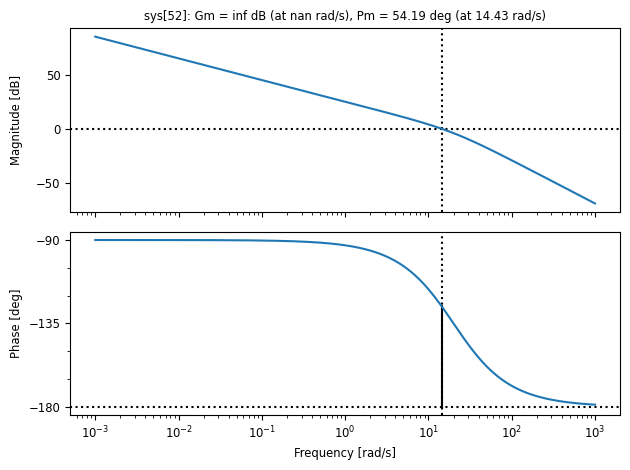

In [ ]:
## Extraction des paramètres de la fonction de transfert en Boucle ouverte
omega = np.logspace(-3, 3, 5000)

#Transfer function
hbo_simplified = ctl.tf([G],[tm,1,0])

# on cherche a savoir quel est le gain à la phase de 120°
p_bo = -120.0
p_bo_rad = p_bo*np.pi/180

# Bode diagram
mag, phase, omega= ctl.bode_plot(hbo_simplified, omega=omega, plot=True,deg =True, dB=True,initial_phase=0,display_margins=True)

# Obtention de la fréquence :
omega_cible = np.argmin(abs(phase - p_bo_rad))
print(f"La fréquence à la phase cible de {p_bo}° est {omega_cible} Hz ")
mag_cible = mag[omega_cible]
print(f"Gain à {omega_cible} Hz : {mag_cible} en decimal ")

#--- Valeur en dur ---
# omega_c=11.6
# g_bo = 10**(2.46/20)



# Montrer le diagramme de Bode
plt.show()

**Vérification par Matlab**

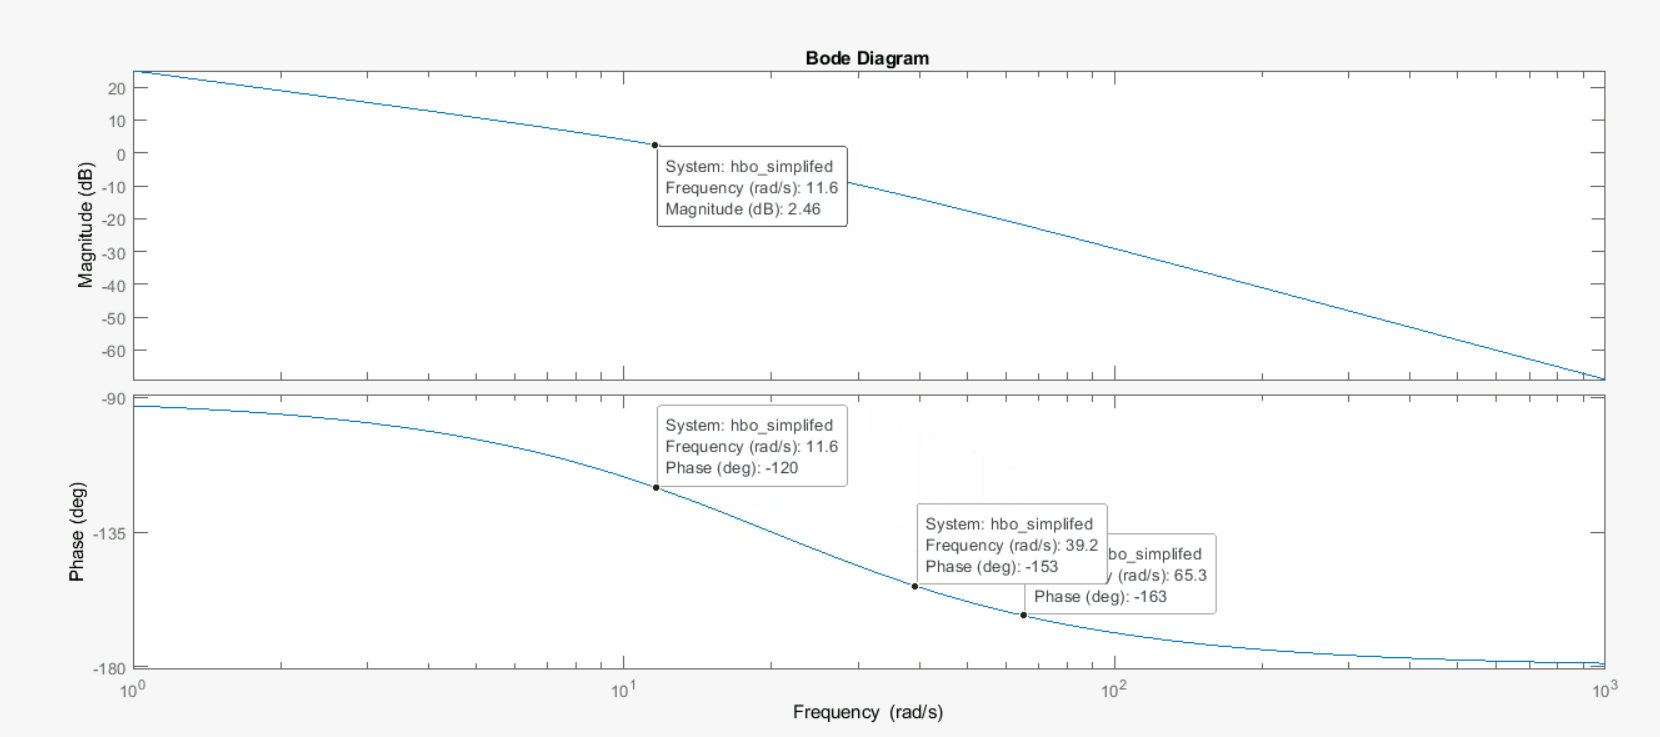


#### Calcul du gain K

Constante de temps du dérivateur Td =  0.74067521125376 s 
Gain du PD K = 0.7499225232329242
Gain du PD pour une marge de phase de 45° = 0.6292256083368785


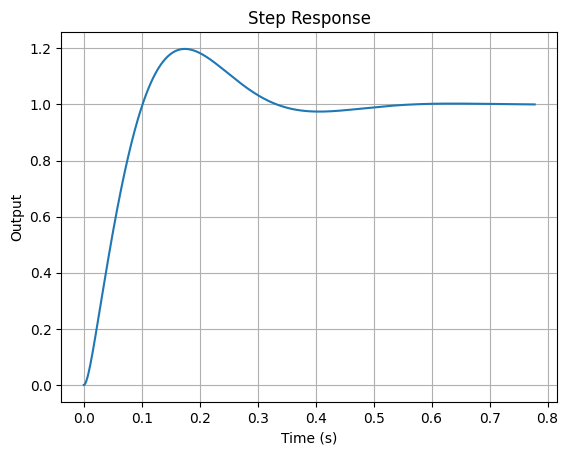

/usr/local/lib/python3.10/dist-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


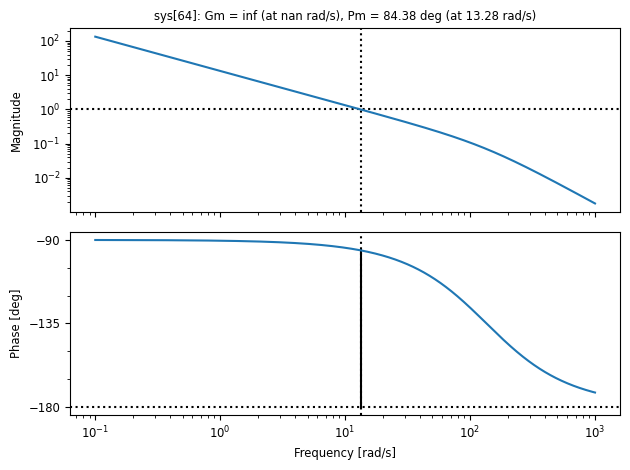

In [ ]:
from re import T
# Paramètres
Phi_m = 60.0 #[deg] Marge de phase

N=100

# D
tau_d=Tau
print("Constante de temps du dérivateur Td = ", tau_d,  "s ")
# K
K=1/mag_cible

# K=2
K_45=(G*tm)/np.sqrt(2) #avec marge de phase de 45°
print(f"Gain du PD K = {K}")
print(f"Gain du PD pour une marge de phase de 45° = {K_45}")

pd = ctl.tf([K*tau_d, K ],[tau_d/N,1])

#Boucle ouverte
hbo_ass =Satellite*pd

# ---- Réponse système asservi ----
hbf_ass = ctl.feedback(pd*Satellite,Sensor,-1)

t, y = ctl.step_response(hbf_ass)

plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response')
plt.grid(True)
plt.show()

#bode plot
mag, phase, omega= ctl.bode(hbo_ass, plot=True, Hz=False, initial_phase=0,display_margins=True)

#### 2.3.3. Validation sur Simulink

En implémentant, le résultat du correcteur PID trouvé précédement dans le modèle Matlab, voici ce que nous obtenons:


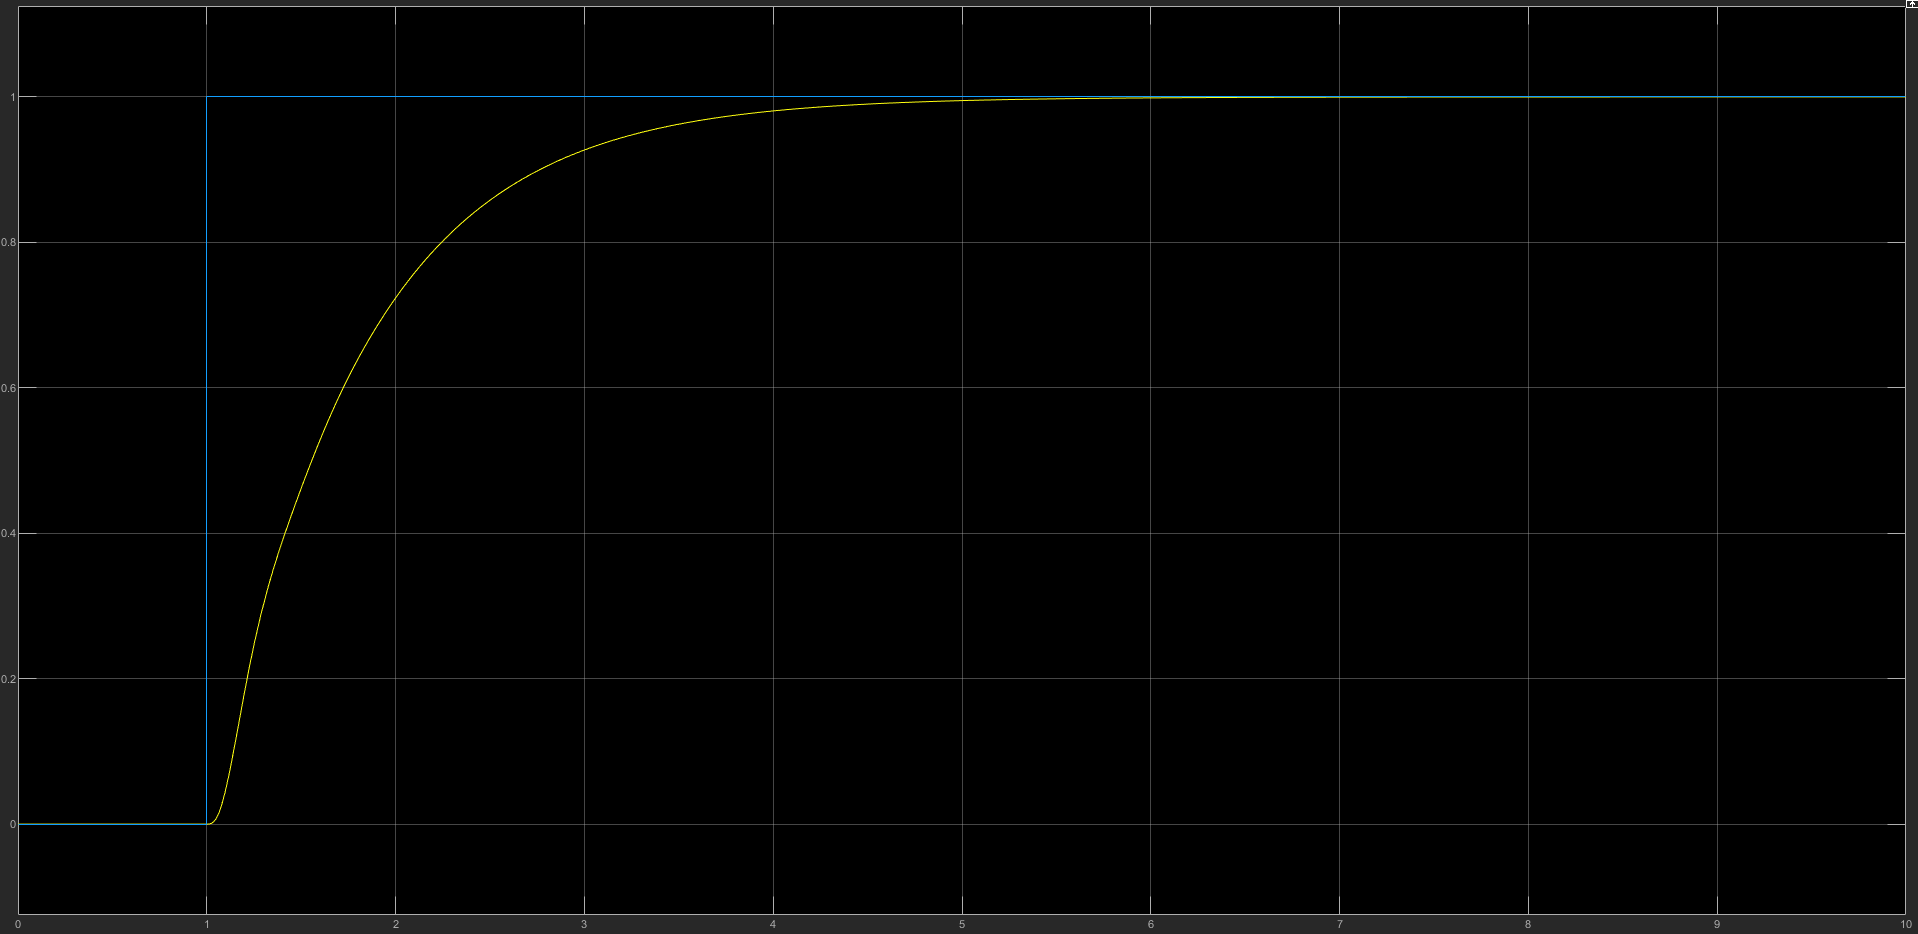

Nous obtenons, un résultat cohérent. Désormais nous pouvons passé à l'implémentation du PID sur le modèle Modelica